<a href="https://colab.research.google.com/github/PaulToronto/Stanford-Andrew-Ng-Machine-Learning-Specialization/blob/main/1_2_2_1_Lab_Feature_scaling_and_learning_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Feature scaling and learning rate

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import copy
import seaborn as sns

from sklearn.linear_model import LinearRegression

np.set_printoptions(precision=2)

## The Data

In [2]:
path = 'https://raw.githubusercontent.com/PaulToronto/'
path += 'Stanford-Andrew-Ng-Machine-Learning-Specialization/main/data/'
path += 'houses2.csv'
houses = pd.read_csv(path, header=None)

In [3]:
houses.columns = ['size_sqft', 'bedrooms', 'floors', 'age', 'price']
houses

,size_sqft,bedrooms,floors,age,price
0,952.0,2.0,1.0,65.0,271.5
1,1244.0,3.0,1.0,64.0,300.0
2,1947.0,3.0,2.0,17.0,509.8
3,1725.0,3.0,2.0,42.0,394.0
4,1959.0,3.0,2.0,15.0,540.0
...,...,...,...,...,...
95,1224.0,2.0,2.0,12.0,329.0
96,1432.0,2.0,1.0,43.0,388.0
97,1660.0,3.0,2.0,19.0,390.0
98,1212.0,3.0,1.0,20.0,356.0


In [4]:
X_features = houses.columns[:-1]
X_features = list(X_features)
X_features

['size_sqft', 'bedrooms', 'floors', 'age']

In [5]:
X_train = houses.drop('price', axis=1).values
y_train = houses['price'].values

## Visualize Features vs. Target

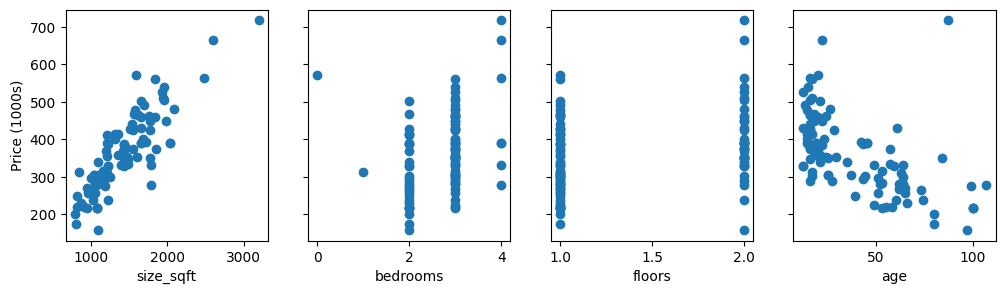

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)

for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel('Price (1000s)')

plt.show()

## Gradient Descent With Multiple Variables
Here are the equations you developed in the last lab on gradient descent for multiple variables.:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j}   \; & \text{for j = 0..n-1}\newline
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value

## Functions

In [7]:
def f_wb(X, w, b):
    m = X.shape[0]
    pred = X @ w + b
    return pred

In [8]:
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = w.dot(X[i]) + b
        cost = cost + (f_wb_i - y[i])**2
    cost = cost / (2 * m)
    return cost

In [9]:
def compute_gradient(X, y, w, b):
    """
    Computes the gradient for linear regression
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b.
    """
    m, n = X.shape
    dj_dw = np.zeros((n, ))
    dj_db = 0.0

    for i in range(m):
        err = w.dot(X[i]) + b - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i, j]
        dj_db = dj_db + err

    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

In [10]:
def compute_gradient_matrix(X, y, w, b):
    """
    Computes the gradient for linear regression

    Args:
      X : (array_like Shape (m,n)) variable such as house size
      y : (array_like Shape (m,1)) actual value
      w : (array_like Shape (n,1)) Values of parameters of the model
      b : (scalar )                Values of parameter of the model
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w.
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b.

    """
    m,n = X.shape
    f_wb = X @ w + b
    e   = f_wb - y
    dj_dw  = (1/m) * (X.T @ e)
    dj_db  = (1/m) * np.sum(e)

    return dj_db,dj_dw

In [11]:
def gradient_descent(X, y, w_in, b_in, f_cost, f_gradient, alpha, num_iters):
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,)) : Updated values of parameters
      b (scalar)       : Updated value of parameter
    """
    J_history = []
    w = copy.deepcopy(w_in) # avoid modify global w within function
    b = b_in

    for i in range(num_iters):
        # calculate the gradient
        dj_db, dj_dw = f_gradient(X, y, w, b)
        collect_w = []

        # update the parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i < 100_000: # prevent resource exhaustion
            J_history.append(f_cost(X, y, w, b))

        # print cost
        if i % ceil(num_iters / 10) == 0:
            print(f'Iteration {i:4d}: Cost {J_history[-1]:8.2f}: w {w}: b {b}')

    return w, b, J_history

In [12]:
#This version saves more values and is more verbose than the assigment versons
def gradient_descent_houses(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X : (array_like Shape (m,n)    matrix of examples
      y : (array_like Shape (m,))    target value of each example
      w_in : (array_like Shape (n,)) Initial values of parameters of the model
      b_in : (scalar)                Initial value of parameter of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """

    # number of training examples
    m = len(X)

    # An array to store values at each iteration primarily for graphing later
    hist={}
    hist["cost"] = []; hist["params"] = []; hist["grads"]=[]; hist["iter"]=[];

    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    save_interval = np.ceil(num_iters/10000) # prevent resource exhaustion for long runs

    print(f"Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  ")
    print(f"---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|")

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J,w,b at each save interval for graphing
        if i == 0 or i % save_interval == 0:
            hist["cost"].append(cost_function(X, y, w, b))
            hist["params"].append([w,b])
            hist["grads"].append([dj_dw,dj_db])
            hist["iter"].append(i)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % ceil(num_iters/10) == 0:
            #print(f"Iteration {i:4d}: Cost {cost_function(X, y, w, b):8.2f}   ")
            cst = cost_function(X, y, w, b)
            print(f"{i:9d} {cst:0.5e} {w[0]: 0.1e} {w[1]: 0.1e} {w[2]: 0.1e} {w[3]: 0.1e} {b: 0.1e} {dj_dw[0]: 0.1e} {dj_dw[1]: 0.1e} {dj_dw[2]: 0.1e} {dj_dw[3]: 0.1e} {dj_db: 0.1e}")

    return w, b, hist #return w,b and history for graphing

In [13]:
def run_gradient_descent(X,y,iterations=1000, alpha = 1e-6):

    m,n = X.shape
    # initialize parameters
    initial_w = np.zeros(n)
    initial_b = 0
    # run gradient descent
    w_out, b_out, hist_out = gradient_descent_houses(X ,y, initial_w, initial_b,
                                               compute_cost, compute_gradient_matrix, alpha, iterations)
    print(f"w,b found by gradient descent: w: {w_out}, b: {b_out:0.2f}")

    return(w_out, b_out, hist_out)

In [14]:
def plot_cost_i_w(X, y, hist):
    ws = np.array([p[0] for p in hist['params']])
    rng = max(abs(ws[:, 0].min()), abs(ws[:, 0].max())) #w_0 with max magnitude
    wr = np.linspace(-rng+0.27, rng+0.27, 20)
    # w_1 = -32, w_2 = -67, w_3 = -1.45, b = 221
    # these values are very cost to `w_best` and `b_best`
    cst = [compute_cost(X,y,np.array([wr[i],-32, -67, -1.46]), 221) for i in range(len(wr))]

    fig, ax = plt.subplots(1, 2, figsize=(12, 3))

    ax[0].plot(hist['iter'], hist['cost'])
    ax[0].set_title('Cost vs Iteration')
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('Cost')

    ax[1].plot(wr, cst)
    ax[1].set_title('Cost vs w[0]')
    ax[1].set_xlabel('w[0]')
    ax[1].set_ylabel('Cost')

    ax[1].plot(ws[:, 0], hist['cost'])

    plt.show()

## `w_best`, `b_best`

In [15]:
model = LinearRegression()
model.fit(X_train, y_train)
w_best = model.coef_
b_best = model.intercept_
w_best, b_best

(array([  0.27, -32.9 , -67.29,  -1.47]), 221.50226366888353)

## Run Gradient Descent

### $\alpha = 9.9e-7$

In [16]:
iterations = 10
alpha = 9.9e-7

In [17]:
w, b, hist = run_gradient_descent(X_train, y_train, iterations, alpha)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 9.31055e+04  5.4e-01  9.9e-04  5.1e-04  1.2e-02  3.6e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 1.22207e+05 -8.0e-02 -1.6e-04 -9.3e-05 -3.2e-03 -4.4e-05  6.3e+05  1.2e+03  6.1e+02  1.6e+04  4.1e+02
        2 1.60562e+05  6.4e-01  1.1e-03  5.8e-04  1.3e-02  4.3e-04 -7.2e+05 -1.3e+03 -6.8e+02 -1.7e+04 -4.8e+02
        3 2.11110e+05 -1.9e-01 -3.7e-04 -2.1e-04 -7.0e-03 -1.0e-04  8.3e+05  1.5e+03  8.0e+02  2.0e+04  5.4e+02
        4 2.77730e+05  7.6e-01  1.4e-03  6.8e-04  1.5e-02  5.2e-04 -9.5e+05 -1.7e+03 -9.0e+02 -2.2e+04 -6.3e+02
        5 3.65531e+05 -3.3e-01 -6.4e-04 -3.6e-04 -1.2e-02 -1.9e-04  1.1e+06  2.0e+03  1.1e+03  2.7e+04  7.1e+02
        6 4.81246e+05  9.2e-01  1.6e-03  8.2e-04  1.7e-02  6.3e-04 -1.3e+06 -2.3e+03 -1.2e+03 -2.9e+04 -

In [18]:
w

array([-0.75, -0.  , -0.  , -0.02])

In [19]:
b

-0.00044712322383020275

In [20]:
hist.keys()

dict_keys(['cost', 'params', 'grads', 'iter'])

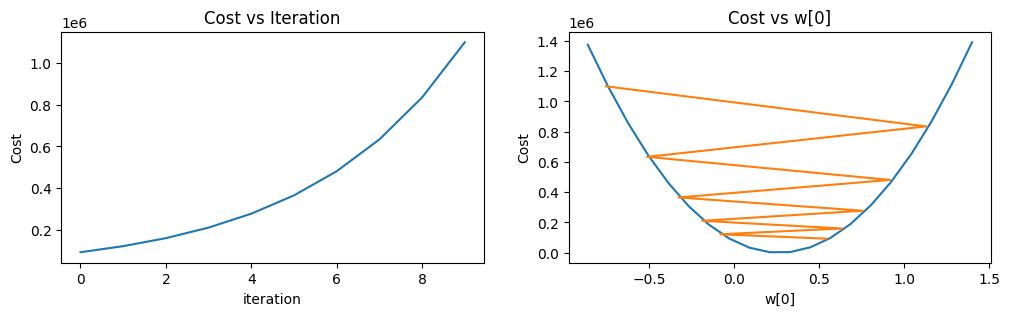

In [21]:
plot_cost_i_w(X_train, y_train, hist)

In [22]:
hist['cost'] # not converging

[93105.49165523131,
 122207.39443625312,
 160561.83794183948,
 211110.49432022255,
 277730.2853999482,
 365530.727845975,
 481245.8136507903,
 633750.4817034585,
 834741.2918412249,
 1099633.5064940723]

In [23]:
np.array([p[0] for p in hist['params']])[:, 0] # the w_0 values

array([ 0.54, -0.08,  0.64, -0.19,  0.76, -0.33,  0.92, -0.51,  1.13,
       -0.75])

The plot on the right shows the value of one of the parameters, $w_0$. At each iteration, it is overshooting the optimal value and as a result, cost ends up *increasing* rather than approaching the minimum. Note that this is not a completely accurate picture as there are 4 parameters being modified each pass rather than just one. This plot is only showing $w_0$ with the other parameters fixed at benign values. In this and later plots you may notice the blue and orange lines being slightly off.

The solution is not converging. Try a smaller $\alpha$.

### $\alpha = 9e-7$

In [24]:
alpha = 9e-7

w, b, hist = run_gradient_descent(X_train, y_train, iterations, alpha)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 6.46137e+04  4.9e-01  9.0e-04  4.6e-04  1.1e-02  3.3e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 5.87949e+04  2.3e-02  3.1e-05  7.5e-06 -6.2e-04  2.3e-05  5.2e+05  9.7e+02  5.1e+02  1.3e+04  3.4e+02
        2 5.35131e+04  4.7e-01  8.5e-04  4.3e-04  9.5e-03  3.2e-04 -5.0e+05 -9.1e+02 -4.7e+02 -1.1e+04 -3.3e+02
        3 4.87187e+04  4.5e-02  5.9e-05  1.3e-05 -1.3e-03  4.5e-05  4.7e+05  8.8e+02  4.6e+02  1.2e+04  3.1e+02
        4 4.43668e+04  4.5e-01  8.0e-04  3.9e-04  7.9e-03  3.1e-04 -4.5e+05 -8.2e+02 -4.2e+02 -1.0e+04 -3.0e+02
        5 4.04165e+04  6.4e-02  8.2e-05  1.7e-05 -2.0e-03  6.5e-05  4.3e+05  8.0e+02  4.2e+02  1.1e+04  2.8e+02
        6 3.68307e+04  4.3e-01  7.5e-04  3.6e-04  6.2e-03  3.1e-04 -4.1e+05 -7.5e+02 -3.8e+02 -9.2e+03 -

In [25]:
w

array([ 9.72e-02,  1.21e-04,  1.89e-05, -3.53e-03])

In [26]:
b

0.0001030267724550236

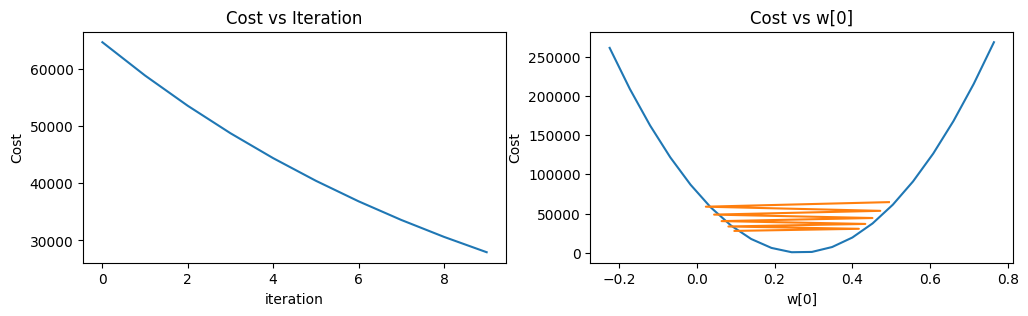

In [27]:
plot_cost_i_w(X_train, y_train, hist)

On the left, you see that cost is decreasing as it should. On the right, you can see that $w_0$ is still oscillating around the minimum, but it is decreasing each iteration rather than increasing. Note above that dj_dw[0] changes sign with each iteration as w[0] jumps over the optimal value. This alpha value will converge. You can vary the number of iterations to see how it behaves.

The solution is now converging, so $\alpha$ is not too large, but it does not appear to be leveling off. Maybe an even smaller value for $\alpha$?

### $\alpha = 1e-7$

In [28]:
alpha = 1e-7

w, b, hist = run_gradient_descent(X_train, y_train, iterations, alpha)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 4.41544e+04  5.5e-02  1.0e-04  5.2e-05  1.2e-03  3.6e-05 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 2.76797e+04  9.8e-02  1.8e-04  9.2e-05  2.2e-03  6.5e-05 -4.3e+05 -7.8e+02 -4.0e+02 -9.6e+03 -2.8e+02
        2 1.75784e+04  1.3e-01  2.4e-04  1.2e-04  2.9e-03  8.7e-05 -3.4e+05 -6.1e+02 -3.1e+02 -7.4e+03 -2.2e+02
        3 1.13850e+04  1.6e-01  2.9e-04  1.5e-04  3.5e-03  1.0e-04 -2.6e+05 -4.8e+02 -2.4e+02 -5.6e+03 -1.8e+02
        4 7.58758e+03  1.8e-01  3.2e-04  1.7e-04  3.9e-03  1.2e-04 -2.1e+05 -3.7e+02 -1.9e+02 -4.3e+03 -1.4e+02
        5 5.25923e+03  1.9e-01  3.5e-04  1.8e-04  4.3e-03  1.3e-04 -1.6e+05 -2.9e+02 -1.5e+02 -3.2e+03 -1.1e+02
        6 3.83162e+03  2.1e-01  3.8e-04  1.9e-04  4.5e-03  1.4e-04 -1.3e+05 -2.3e+02 -1.1e+02 -2.4e+03 -

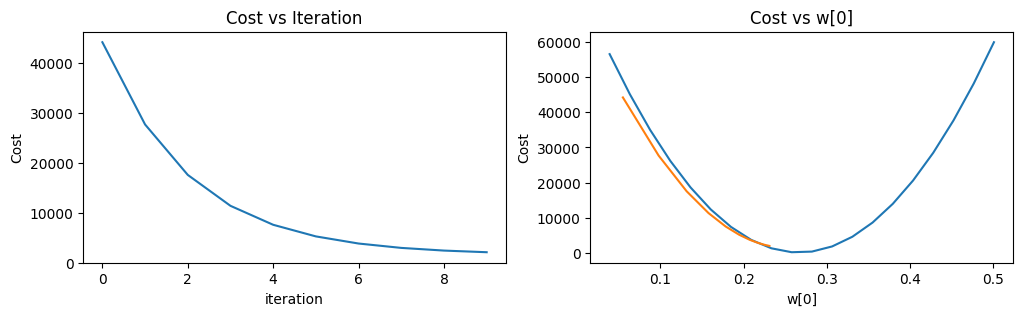

In [29]:
plot_cost_i_w(X_train, y_train, hist)

## Feature Scaling

### z-score normaliztion

After z-score normalization, all features will have a mean of 0 and a standard deviation of 1

$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j}$$

In [30]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray (m,n))     : input data, m examples, n features

    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each feature
    mu = np.mean(X, axis=0)
    # find the standard deviation of each feature
    sigma = np.std(X, axis=0)
    # element-wise, subtract mean for each column and divide by standard deviation
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

### The relationship between `size_sqft` and `age`, before and after z-score normalization

- Note that these are plotted with **equal scale**

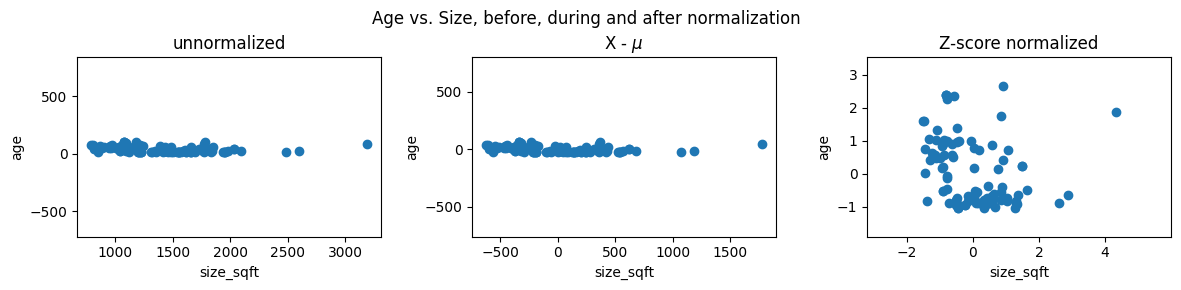

In [31]:
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
X_mean = X_train - X_mu

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].scatter(X_train[:, 0], X_train[:, 3])
ax[0].set_xlabel(X_features[0])
ax[0].set_ylabel(X_features[3])
ax[0].set_title('unnormalized')
ax[0].axis('equal')

ax[1].scatter(X_mean[:, 0], X_mean[:, 3])
ax[1].set_xlabel(X_features[0])
ax[1].set_ylabel(X_features[3])
ax[1].set_title(r'X - $\mu$')
ax[1].axis('equal')

ax[2].scatter(X_norm[:, 0], X_norm[:, 3])
ax[2].set_xlabel(X_features[0])
ax[2].set_ylabel(X_features[3])
ax[2].set_title('Z-score normalized')
ax[2].axis('equal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Age vs. Size, before, during and after normalization')

plt.show()

### Comparing `X_train`, to `X_norm`

In [32]:
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

X_mu = [1.41e+03 2.71e+00 1.38e+00 3.86e+01], 
X_sigma = [412.17   0.65   0.49  25.79]
Peak to Peak range by column in Raw        X:[2.41e+03 4.00e+00 1.00e+00 9.50e+01]
Peak to Peak range by column in Normalized X:[5.84 6.13 2.06 3.68]


Notice the reduction in the **peak to peak range** of each feature.

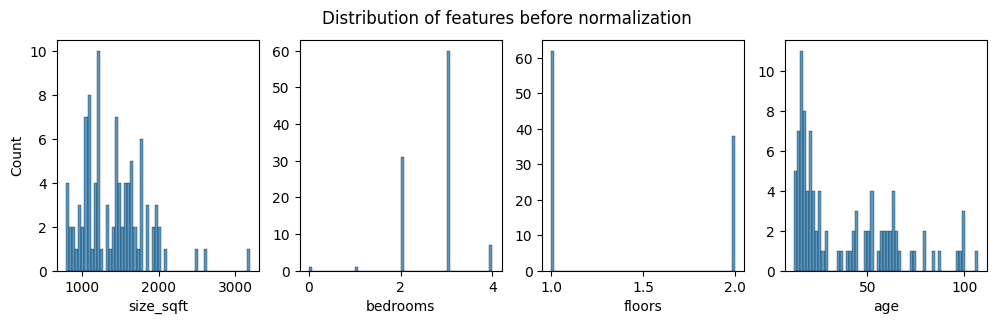

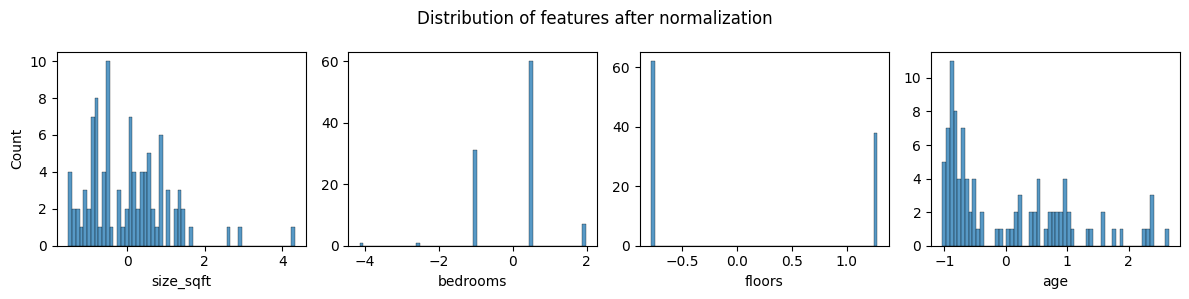

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    sns.histplot(X_train[:, i], bins=60, ax=ax[i])
    ax[i].set(xlabel=X_features[i], ylabel=None)
ax[0].set_ylabel('Count')
fig.suptitle('Distribution of features before normalization')
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    sns.histplot(X_norm[:, i], bins=60, ax=ax[i])
    ax[i].set(xlabel=X_features[i], ylabel=None)
ax[0].set_ylabel('Count')
fig.suptitle('Distribution of features after normalization')
plt.tight_layout()
plt.show()

### `w_best_norm`, `b_best_norm`

In [34]:
model = LinearRegression()
model.fit(X_norm, y_train)
w_best_norm = model.coef_
b_best_norm = model.intercept_
w_best_norm, b_best_norm

(array([110.61, -21.47, -32.66, -37.78]), 362.23952)

### Running Gradient Descent After Z-score Normalization

#### $\alpha = 1.0e-1$

In [35]:
alpha = 1.0e-1
iterations = 10

# this is NOT converging
w_norm, b_norm, hist = run_gradient_descent(X_train, y_train, iterations, alpha)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 3.26964e+15  5.5e+04  1.0e+02  5.2e+01  1.2e+03  3.6e+01 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 1.53922e+26 -1.2e+10 -2.2e+07 -1.1e+07 -2.8e+08 -7.8e+06  1.2e+11  2.2e+08  1.1e+08  2.8e+09  7.8e+07
        2 7.24600e+36  2.6e+15  4.7e+12  2.5e+12  6.2e+13  1.7e+12 -2.6e+16 -4.7e+13 -2.5e+13 -6.2e+14 -1.7e+13
        3 3.41112e+47 -5.6e+20 -1.0e+18 -5.4e+17 -1.3e+19 -3.7e+17  5.6e+21  1.0e+19  5.4e+18  1.3e+20  3.7e+18
        4 1.60582e+58  1.2e+26  2.2e+23  1.2e+23  2.9e+24  7.9e+22 -1.2e+27 -2.2e+24 -1.2e+24 -2.9e+25 -7.9e+23
        5 7.55954e+68 -2.6e+31 -4.8e+28 -2.5e+28 -6.3e+29 -1.7e+28  2.6e+32  4.8e+29  2.5e+29  6.3e+30  1.7e+29
        6 3.55872e+79  5.7e+36  1.1e+34  5.5e+33  1.4e+35  3.7e+33 -5.7e+37 -1.1e+35 -5.5e+34 -1.4e+36 -

In [36]:
# this is converging
w_norm, b_norm, hist = run_gradient_descent(X_norm, y_train, iterations, alpha)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 5.73264e+04  8.9e+00  3.0e+00  3.3e+00 -6.0e+00  3.6e+01 -8.9e+01 -3.0e+01 -3.3e+01  6.0e+01 -3.6e+02
        1 4.63980e+04  1.6e+01  5.1e+00  5.6e+00 -1.1e+01  6.9e+01 -7.5e+01 -2.1e+01 -2.2e+01  5.1e+01 -3.3e+02
        2 3.76444e+04  2.3e+01  6.4e+00  6.9e+00 -1.5e+01  9.8e+01 -6.4e+01 -1.3e+01 -1.4e+01  4.3e+01 -2.9e+02
        3 3.06105e+04  2.8e+01  7.2e+00  7.6e+00 -1.9e+01  1.2e+02 -5.4e+01 -7.5e+00 -7.2e+00  3.7e+01 -2.6e+02
        4 2.49437e+04  3.3e+01  7.5e+00  7.9e+00 -2.2e+01  1.5e+02 -4.7e+01 -3.3e+00 -2.1e+00  3.1e+01 -2.4e+02
        5 2.03686e+04  3.7e+01  7.5e+00  7.7e+00 -2.5e+01  1.7e+02 -4.1e+01 -3.6e-02  1.7e+00  2.7e+01 -2.1e+02
        6 1.66684e+04  4.1e+01  7.2e+00  7.2e+00 -2.7e+01  1.9e+02 -3.7e+01  2.4e+00  4.5e+00  2.3e+01 -

Notice that z-score normalization allows us to use a vastly larger $\alpha$ to speed up gradient descent. Let's try it with more iterations.

In [37]:
iterations = 1000

In [38]:
w_norm, b_norm, hist = run_gradient_descent(X_norm, y_train, iterations, alpha)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 5.73264e+04  8.9e+00  3.0e+00  3.3e+00 -6.0e+00  3.6e+01 -8.9e+01 -3.0e+01 -3.3e+01  6.0e+01 -3.6e+02
      100 2.21728e+02  1.1e+02 -2.0e+01 -3.1e+01 -3.8e+01  3.6e+02 -9.4e-01  4.6e-01  5.4e-01 -1.8e-01 -9.6e-03
      200 2.19714e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.3e-02  1.6e-02  1.8e-02 -6.4e-03 -2.6e-07
      300 2.19711e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.1e-03  5.7e-04  6.3e-04 -2.2e-04 -6.9e-12
      400 2.19711e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -3.9e-05  2.0e-05  2.2e-05 -7.6e-06 -2.7e-13
      500 2.19711e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -1.3e-06  6.8e-07  7.5e-07 -2.6e-07 -2.2e-13
      600 2.19711e+02  1.1e+02 -2.1e+01 -3.3e+01 -3.8e+01  3.6e+02 -4.7e-08  2.4e-08  2.6e-08 -9.1e-09 -

In [39]:
w_norm, w_best_norm # very close!

(array([110.61, -21.47, -32.66, -37.78]),
 array([110.61, -21.47, -32.66, -37.78]))

In [40]:
b_norm, b_best_norm #very close!

(362.2395199999998, 362.23952)

### Plot Predictions vs. Target Values

- Note that the predictions are made using normalized features, while the plot is shown using the origianl feature values.

In [41]:
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w) + b
yp

array([-2.54e-01, -9.02e-02,  2.95e-01,  1.76e-01,  3.02e-01, -6.10e-02,
       -3.03e-01,  2.33e-01, -2.16e-01,  1.01e+00, -3.43e-01, -1.24e-01,
        7.60e-02,  5.79e-03, -1.14e-01, -1.76e-01, -3.22e-01,  1.48e-01,
        1.95e-01, -2.08e-01,  1.30e-01, -1.84e-01, -5.92e-02,  9.52e-02,
       -2.42e-01, -1.78e-01, -2.28e-01, -2.82e-01,  1.52e-01, -1.80e-01,
       -1.30e-04, -1.37e-01,  2.88e-01, -1.04e-01,  5.96e-01, -1.24e-01,
        2.36e-01,  2.49e-01,  1.35e-01, -1.67e-01,  2.01e-01,  3.48e-01,
        2.22e-01, -1.80e-01,  7.34e-02,  2.99e-01, -1.11e-01,  1.09e-01,
       -3.32e-01, -3.94e-02,  8.37e-02,  4.42e-02,  4.70e-02, -1.80e-01,
        1.94e-01, -1.20e-01,  2.94e-02,  2.08e-01,  1.31e-01, -2.11e-01,
       -1.69e-01, -1.43e-01, -3.35e-01, -2.12e-01, -7.21e-03,  1.05e-01,
       -1.07e-01, -1.80e-01,  6.63e-01,  1.37e-02,  3.77e-01,  2.14e-01,
        3.57e-02, -2.12e-01,  6.72e-03, -1.40e-01,  7.03e-02,  3.17e-01,
       -1.98e-01, -1.20e-01, -3.58e-02, -2.52e-01, 

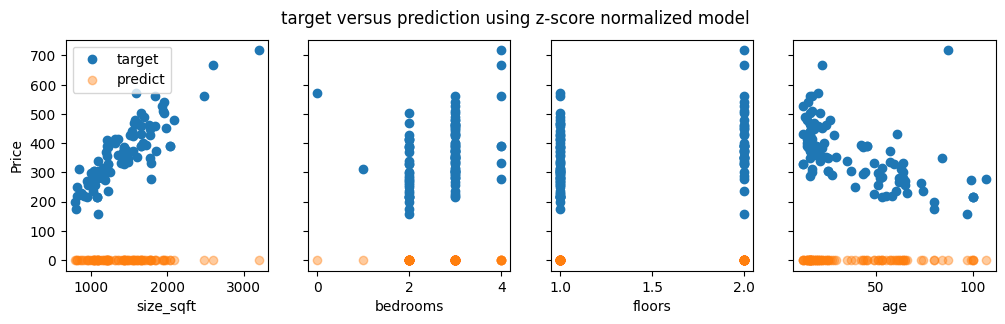

In [42]:
# predictions
y_pred = f_wb(X_norm, w, b)

fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train, label='target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:, i], y_pred, label='predict', alpha=0.4)
ax[0].set_ylabel('Price')
ax[0].legend()
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

### Prediction

The point of generating our model is to use it to predict housing prices that are not in the data set. Let's predict the price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old. Recall, that you must normalize the data with the mean and standard deviation derived when the training data was normalized.

In [43]:
x_house = np.array([1200, 3, 1, 40])
x_house_norm = (x_house - X_mu) / X_sigma
x_house_norm

array([-0.52,  0.44, -0.78,  0.05])

In [44]:
f_wb(x_house_norm, w, b)  # in thousands of dollars

-0.11936937726742138

In [45]:
model.predict(x_house_norm.reshape(1, -1))

array([318.94])

## Cost Contours

- When feature scales do not match, the plot of cost vs. parameters in a contour plot is asymmetric

In [46]:
# plots p1 vs p2. Prange is an array of entries [min, max, steps]. In feature scaling lab.
def plt_contour_multi(x, y, w, b, ax, prange, p1, p2, title="", xlabel="", ylabel=""):
    contours = [1e2, 2e2,3e2,4e2, 5e2, 6e2, 7e2,8e2,1e3, 1.25e3,1.5e3, 1e4, 1e5, 1e6, 1e7]
    px,py = np.meshgrid(np.linspace(*(prange[p1])),np.linspace(*(prange[p2])))
    z=np.zeros_like(px)
    n,_ = px.shape
    for i in range(px.shape[0]):
        for j in range(px.shape[1]):
            w_ij = w
            b_ij = b
            if p1 <= 3: w_ij[p1] = px[i,j]
            if p1 == 4: b_ij = px[i,j]
            if p2 <= 3: w_ij[p2] = py[i,j]
            if p2 == 4: b_ij = py[i,j]

            z[i][j] = compute_cost(x, y, w_ij, b_ij )
    CS = ax.contour(px, py, z, contours, linewidths=2,
                   colors=['blue', 'orange', 'darkred', 'magenta', 'purple'])
    ax.clabel(CS, inline=1, fmt='%1.2e', fontsize=10)
    ax.set_xlabel(xlabel);  ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=14)

def plt_equal_scale(X_train, X_norm, y_train):
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    prange = [
              [ 0.238-0.045, 0.238+0.045,  50],
              [-25.77326319-0.045, -25.77326319+0.045, 50],
              [-50000, 0,      50],
              [-1500,  0,      50],
              [0, 200000, 50]]
    w_best = np.array([0.23844318, -25.77326319, -58.11084634,  -1.57727192])
    b_best = 235
    plt_contour_multi(X_train, y_train, w_best, b_best, ax[0], prange, 0, 1,
                      title='Unnormalized, J(w,b), vs w[0],w[1]',
                      xlabel= "w[0] (size(sqft))", ylabel="w[1] (# bedrooms)")
    #
    w_best = np.array([111.1972, -16.75480051, -28.51530411, -37.17305735])
    b_best = 376.949151515151
    prange = [[ 111-50, 111+50,   75],
              [-16.75-50,-16.75+50, 75],
              [-28.5-8, -28.5+8,  50],
              [-37.1-16,-37.1+16, 50],
              [376-150, 376+150, 50]]
    plt_contour_multi(X_norm, y_train, w_best, b_best, ax[1], prange, 0, 1,
                      title='Normalized, J(w,b), vs w[0],w[1]',
                      xlabel= "w[0] (normalized size(sqft))", ylabel="w[1] (normalized # bedrooms)")
    fig.suptitle("Cost contour with equal scale", fontsize=18)
    #plt.tight_layout(rect=(0,0,1.05,1.05))
    fig.tight_layout(rect=(0,0,1,0.95))
    plt.show()

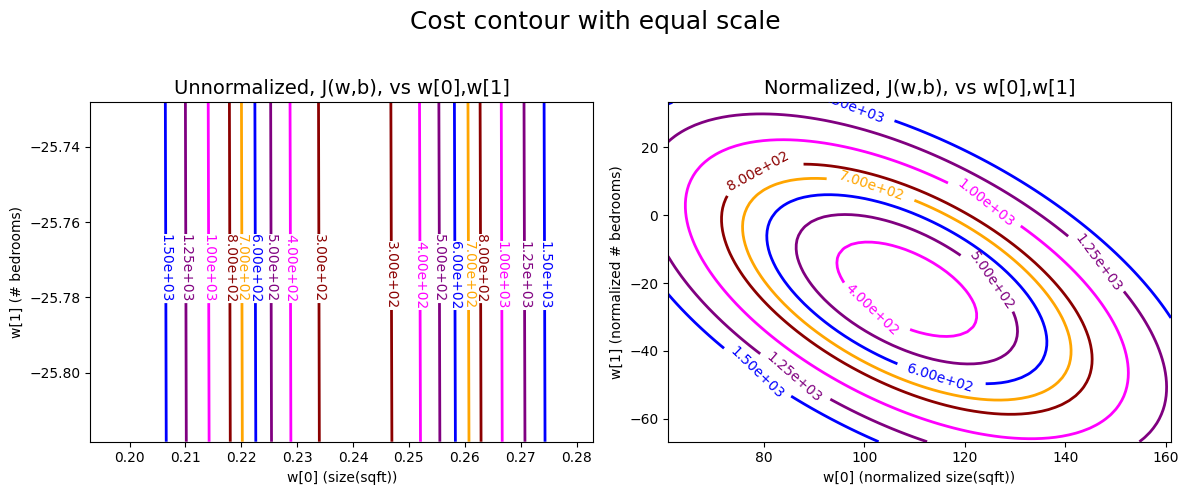

In [47]:
plt_equal_scale(X_train,X_norm, y_train)